In [1]:
import DeepMIMO
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from scipy.io import loadmat, savemat

In [2]:
# Load the default parameters
parameters = DeepMIMO.default_params()

# Set scenario name
parameters['scenario'] = 'O1_60'

# Set the main folder containing extracted scenarios
parameters['dataset_folder'] = r'C:\\Users\\emre.topcu\\Desktop\\ulakws\\scenarios\\O1_60'

In [3]:
# Only include 10 strongest paths in the channel computation, set
parameters['num_paths'] = 5

# User rows 
parameters['user_row_first'] = 200
parameters['user_row_last'] = 5100
# Activate the half of the users in each selected row randomly, set
parameters['user_subsampling'] = 0.0001

# Activate the basestations 1, 7, 14, and 18
parameters['active_BS'] = np.array([1, 7, 14, 18]) 

# Total bandwidth of the channel in GHz. 
parameters['OFDM']['bandwidth'] = 0.05 # 50 MHz
# Generate OFDM channels with 256 subcarriers
parameters['OFDM']['subcarriers'] = 1024 # OFDM with 1024 subcarriers
# Construct channels that will be calculated only at the sampled subcarriers
parameters['OFDM']['subcarriers_limit'] = 64 # Keep only first 64 subcarriers

# Enable (1) or disable (0) generation of the channels between basestations
parameters['enable_BS2BS'] = False

parameters['ue_antenna']['shape'] = np.array([1, 1, 1]) # Single antenna

# Adopt a 32x4 UPA in y-z directions
parameters['bs_antenna']['shape'] = np.array([1, 32, 4]) # ULA of 32 elements
# Spacing 0.5*wavelength
parameters['bs_antenna']['spacing'] = 0.5
# Rotate BSs 30 degrees around z-axis, set
parameters['bs_antenna']['rotation'] = np.array([0, 0, 30])

parameters['bs_antenna']['radiation_pattern'] = 'halfwave-dipole'
parameters['ue_antenna']['radiation_pattern'] = 'halfwave-dipole'

In [4]:
# Generate data
dataset = DeepMIMO.generate_data(parameters)

# Print the default parameters
for i,j in parameters.items():
    print(i,": ,", j)



Basestation 1

UE-BS Channels


Generating channels: 100%|██████████| 4901/4901 [00:03<00:00, 1364.22it/s]



Basestation 7

UE-BS Channels


Generating channels: 100%|██████████| 4901/4901 [00:04<00:00, 998.54it/s] 



Basestation 14

UE-BS Channels


Generating channels: 100%|██████████| 4901/4901 [00:02<00:00, 1643.65it/s]



Basestation 18

UE-BS Channels


Generating channels: 100%|██████████| 4901/4901 [00:05<00:00, 965.78it/s] 

dataset_folder : , C:\\Users\\emre.topcu\\Desktop\\ulakws\\scenarios\\O1_60
scenario : , O1_60
dynamic_settings : , {'first_scene': 1, 'last_scene': 1}
num_paths : , 5
active_BS : , [ 1  7 14 18]
user_row_first : , 200
user_row_last : , 5100
row_subsampling : , 1
user_subsampling : , 0.0001
bs_antenna : , [{'shape': array([ 1, 32,  4]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([ 0,  0, 30])}, {'shape': array([ 1, 32,  4]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([ 0,  0, 30])}, {'shape': array([ 1, 32,  4]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([ 0,  0, 30])}, {'shape': array([ 1, 32,  4]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([ 0,  0, 30])}]
ue_antenna : , {'shape': array([1, 1, 1]), 'spacing': 0.5, 'radiation_pattern': 'halfwave-dipole', 'rotation': array([None, None, None, ..., None, None, None], dtype=object)}
enable_BS2BS : , False
OFDM_chann

In [5]:
print("Shape of the dataset: ", dataset[0]['user']['channel'].shape)
print("Shape of the dataset: (ue_count, number of RX antennas, number of TX antennas, subcarrier_lmt) \n")
print("Number of TX antennas: ", len(dataset))
print("BS1 Location: ", dataset[0]['location'],"\n")
print("UE specifications: ", dataset[0]['user'].keys())

Shape of the dataset:  (4901, 1, 128, 64)
Shape of the dataset: (ue_count, number of RX antennas, number of TX antennas, subcarrier_lmt) 

Number of TX antennas:  4
BS1 Location:  [235.5039978 389.5039978   6.       ] 

UE specifications:  dict_keys(['paths', 'LoS', 'location', 'distance', 'pathloss', 'channel'])


In [6]:
def beamforming_codebook(ant_shape = np.array([1, 32, 1]), oversampling_rate = np.array([1, 1, 1]), kd = 0.5):
    
    kd = 2 * np.pi * kd
    codebook_size = ant_shape * oversampling_rate
    
    vecs = []
    for dim in range(3):
        # Transpose
        ind = np.arange(ant_shape[dim]).reshape((-1, 1))
        codebook_ang = np.linspace(0, np.pi, codebook_size[dim], endpoint = False).reshape((1, -1))                                                                                                     
        vec = np.sqrt(1./ant_shape[dim]) * np.exp(-1j * kd * ind * np.cos(codebook_ang))
        vecs.append(vec)
        
    F = np.kron(vecs[2], np.kron(vecs[1], vecs[0]))
    
    return F

In [7]:
# Codebook values
F = beamforming_codebook(ant_shape = parameters['bs_antenna'][0]['shape'], oversampling_rate = np.array([1, 2, 1]), kd = parameters['bs_antenna'][0]['spacing'])

In [8]:
F.shape

(128, 256)

In [9]:
num_OFDM = int(parameters['OFDM']['subcarriers_limit']/parameters['OFDM']['subcarriers_sampling'])
num_beams = F.shape[1]
num_bs = len(parameters['active_BS'])
num_ue = len(parameters['active_UE'])

print("Number of OFDM subcarrier limit: ", num_OFDM)
print("Number of beams: ", num_beams)
print("Number of active BSs: ", num_bs)
print("Number of active UEs: ", num_ue)

Number of OFDM subcarrier limit:  64
Number of beams:  256
Number of active BSs:  4
Number of active UEs:  4901


In [10]:
# Noise figure at the base station
NF = 5
# Channel estimation processing gain          
Process_Gain = 10
# System bandwidth in Hz
BW = parameters['OFDM']['bandwidth'] * 1e9
# Noise power in dB
noise_power_dB = -204 + 10*np.log10(BW/parameters['OFDM']['subcarriers']) + NF - Process_Gain
# Noise power
noise_power = 10**(.1*(noise_power_dB))

In [11]:
def normalization_reshape(dataset, num_bs, num_ue, num_OFDM, num_beams):
    """
    Normalization and reshaping processes on model input-output data.

    Args:
        dataset (_type_): Ray tracing simulation results
        num_bs (_type_): Number of base stations
        num_ue (_type_): Number of user equipments
        num_OFDM (_type_): Number of OFDM subcarrier limi
        num_beams (_type_): Number of beams in codebook
    
    Returns:
        
    """
    input_norm = np.zeros((num_bs, num_ue, num_OFDM), dtype=complex)
    max_rates = np.zeros((num_bs, num_ue, num_beams))
    
    # Each BS
    for bs_idx in tqdm(range(num_bs), desc='Neural Network Input-Output Generation-BS', position=0, leave=True):
        # Each UE
        for ue_idx in tqdm(range(num_ue), desc='Neural Network Input-Output Generation-BS-%i'%bs_idx, position=0, leave=True):
            ch = dataset[bs_idx]['user']['channel'][ue_idx].squeeze()
            ch = ch + np.sqrt(noise_power) * (np.random.randn(*(ch.shape)) + 1j * np.random.randn(*(ch.shape)))
            input_norm[bs_idx, ue_idx, :] = ch[0, :]
            max_rates[bs_idx, ue_idx, :] = np.sum(np.log2(1 + np.abs(ch.T.conj() @ F)**2),  axis = 0)/num_OFDM
        
    # Input reshape - normalize
    print("\nShape of input before normalization: ", input_norm.shape)
    input_norm = np.transpose(input_norm, axes=[1, 0, 2]) # [x y z] -> [y, x, z]
    input_norm = input_norm.reshape((num_ue, -1)) # [y, x ,z] -> [y, z_x0 z_x1]
    input_norm /=  np.amax(np.abs(input_norm))
    print("Shape of input after normalization: ", input_norm.shape, "\n")
    
    # Output reshape - normalize
    print("Shape of output before normalization: ", max_rates.shape)
    max_rates_norm_factor = np.amax(max_rates, axis=2, keepdims=True)
    # Do not normalize if all zeros
    max_rates_norm_factor[max_rates_norm_factor == 0] = 1
    max_rates /= max_rates_norm_factor
    max_rates = np.transpose(max_rates, axes=[1, 0, 2]) # [x y z] -> [y, x, z]
    max_rates = max_rates.reshape((num_ue, -1)) # [y, x ,z] -> [y, z_x0 z_x1]
    print("Shape of output before normalization: ", max_rates.shape)
    
    
    if not os.path.exists('./DLCB_dataset'):
                      os.makedirs('DLCB_dataset')
    savemat('./DLCB_dataset/DLCB_input.mat', {'DL_input': input_norm})
    savemat('./DLCB_dataset/DLCB_output.mat', {'DL_output': max_rates})
    
    
    return
    
    

In [12]:
normalization_reshape(dataset, num_bs, num_ue, num_OFDM, num_beams)

Neural Network Input-Output Generation-BS: 100%|██████████| 4/4 [00:52<00:00, 13.23s/it]



Shape of input before normalization:  (4, 4901, 64)
Shape of input after normalization:  (4901, 256) 

Shape of output before normalization:  (4, 4901, 256)
Shape of output before normalization:  (4901, 1024)


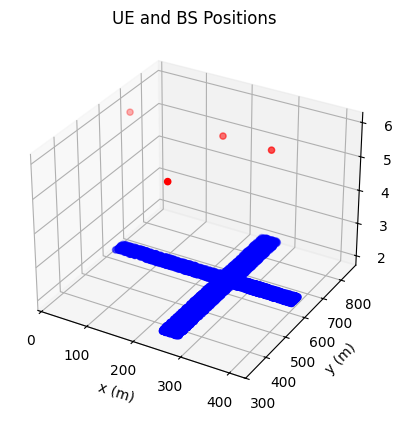

In [13]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

x=np.zeros(num_ue + num_bs)
y=np.zeros(num_ue + num_bs)
z=np.zeros(num_ue + num_bs)

# BS locations
for bs_idx in range(num_bs):
    x[bs_idx] = dataset[bs_idx]['location'][0]
    y[bs_idx] = dataset[bs_idx]['location'][1]
    z[bs_idx] = dataset[bs_idx]['location'][2]
    # UE locations  3 -> x,y,z (0,1,2)
    for ue_idx in range(0, num_ue):
        idx = ue_idx + num_bs
        x[idx] = dataset[bs_idx]['user']['location'][ue_idx][0]
        y[idx] = dataset[bs_idx]['user']['location'][ue_idx][1]
        z[idx] = dataset[bs_idx]['user']['location'][ue_idx][2]
        
ttl = plt.title('UE and BS Positions')

# Plotting UE and BS locations on 3D space
ax.scatter(x[:num_bs], y[:num_bs], z[:num_bs], c='red')
ax.scatter(x[num_bs:], y[num_bs:], z[num_bs:], c='blue')

In [14]:
pathloss = dataset[bs_idx]['user']['pathloss']

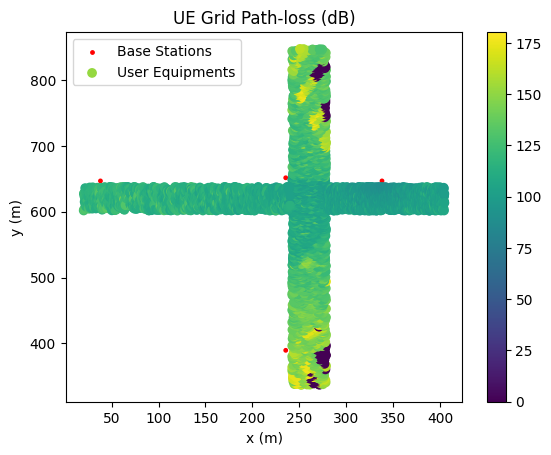

In [15]:
fig = plt.figure()
ax = fig.add_subplot()

pathloss = dataset[bs_idx]['user']['pathloss']
# BS locations
ax.scatter(x[:num_bs], y[:num_bs], z[:num_bs], c='red')
# UE locations
im = ax.scatter(x[num_bs:], y[num_bs:], c=pathloss)

ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
fig.colorbar(im, ax=ax)
title = plt.title('UE Grid Path-loss (dB)')
plt.legend(["Base Stations", "User Equipments"])


In [16]:
# Antenna indices of the channel element in the x, y, z directions.
antennamap = DeepMIMO.ant_indices(parameters['ue_antenna']['shape'])
print(antennamap)

[[0 0 0]]


In [17]:
# Ray-tracing Path Parameters
dataset[0]['user']['paths'][0].keys()

dict_keys(['num_paths', 'DoD_phi', 'DoD_theta', 'DoA_phi', 'DoA_theta', 'phase', 'ToA', 'power'])

In [18]:
# Line-of-Sight Status
dataset[0]['user']['LoS'][0] # Integer of values {-1 (No paths), 0 (NLoS), 1 (LoS)}

# The Euclidian distance between the RX and TX locations in meters.
dataset[0]['user']['distance'][0]

# The combined path-loss of the channel between the RX and TX in dB
dataset[0]['user']['pathloss'][0]

# The Euclidian location of the UE in the form of [x, y, z].
dataset[0]['user']['location'][0]

# The Euclidian location of the BS in the form of [x, y, z].
dataset[0]['location']

array([235.5039978, 389.5039978,   6.       ])

Text(0, 0.5, 'Subcarriers')

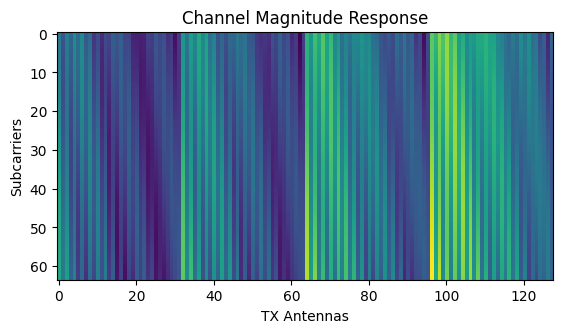

In [19]:
## Visualization of a channel matrix

plt.figure()

# Visualize channel magnitude response
ue_idx = 200
bs_idx = 0

# Import channel
channel = dataset[bs_idx]['user']['channel'][ue_idx]

# Take only the first antenna pair
plt.imshow(np.abs(np.squeeze(channel).T))
plt.title('Channel Magnitude Response')
plt.xlabel('TX Antennas')
plt.ylabel('Subcarriers')